In [65]:
import h5py, numpy as np, matplotlib.pyplot as plt, torch, torch.nn as nn, onnx
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [66]:
dim = 32
pred_steps = 5
with h5py.File("/kaggle/input/life-32-10-50k/life_32_10_50k.h5", "r") as f:
    # use slicing to pull the entire dataset into memory immediately
    X = f["X"][:]
    y = f["Y"][:]
print(X.shape, y.shape)

(50000, 32, 32) (50000, 32, 32)


In [67]:
pos = X.mean()    # fraction of alive cells
neg = 1 - pos

print(neg/pos)

1.007714013686963


In [68]:
class Life_CNN(nn.Module):
    def __init__(self, m=24):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 2*m, kernel_size=3, padding=1), nn.BatchNorm2d(2*m), nn.ReLU(),
            nn.Conv2d(2*m,    m, kernel_size=1),         nn.BatchNorm2d(m),    nn.ReLU(),

            nn.Conv2d(m,   2*m, kernel_size=3, padding=1), nn.BatchNorm2d(2*m), nn.ReLU(),
            nn.Conv2d(2*m,    m, kernel_size=1),          nn.BatchNorm2d(m),    nn.ReLU(),

            nn.Conv2d(m,   2*m, kernel_size=3, padding=1), nn.BatchNorm2d(2*m), nn.ReLU(),
            nn.Conv2d(2*m,    m, kernel_size=1),          nn.BatchNorm2d(m),    nn.ReLU(),

            nn.Conv2d(m,   2*m, kernel_size=3, padding=1), nn.BatchNorm2d(2*m), nn.ReLU(),
            nn.Conv2d(2*m,    m, kernel_size=1),          nn.BatchNorm2d(m),    nn.ReLU(),

            nn.Conv2d(m,   2*m, kernel_size=3, padding=1), nn.BatchNorm2d(2*m), nn.ReLU(),
            nn.Conv2d(2*m,    m, kernel_size=1),          nn.BatchNorm2d(m),    nn.ReLU(),

            nn.Conv2d(m,   2*m, kernel_size=3, padding=1), nn.BatchNorm2d(2*m), nn.ReLU(),
            nn.Conv2d(2*m,    m, kernel_size=1),          nn.BatchNorm2d(m),    nn.ReLU(),

            nn.Conv2d(m,   2*m, kernel_size=3, padding=1), nn.BatchNorm2d(2*m), nn.ReLU(),
            nn.Conv2d(2*m,    m, kernel_size=1),          nn.BatchNorm2d(m),    nn.ReLU(),

            nn.Conv2d(m,   2*m, kernel_size=3, padding=1), nn.BatchNorm2d(2*m), nn.ReLU(),
            nn.Conv2d(2*m,    m, kernel_size=1),          nn.BatchNorm2d(m),    nn.ReLU(),

            nn.Conv2d(m,   2*m, kernel_size=3, padding=1), nn.BatchNorm2d(2*m), nn.ReLU(),
            nn.Conv2d(2*m,    m, kernel_size=1),          nn.BatchNorm2d(m),    nn.ReLU(),

            nn.Conv2d(m,   2*m, kernel_size=3, padding=1), nn.BatchNorm2d(2*m), nn.ReLU(),
            nn.Conv2d(2*m,    m, kernel_size=1),          nn.BatchNorm2d(m),    nn.ReLU(),

            nn.Conv2d(m,   2*m, kernel_size=3, padding=1), nn.BatchNorm2d(2*m), nn.ReLU(),
            nn.Conv2d(2*m,    m, kernel_size=1),          nn.BatchNorm2d(m),    nn.ReLU(),

            nn.Conv2d(m,   2*m, kernel_size=3, padding=1), nn.BatchNorm2d(2*m), nn.ReLU(),
            nn.Conv2d(2*m,    m, kernel_size=1),          nn.BatchNorm2d(m),    nn.ReLU(),

            nn.Conv2d(m,   2*m, kernel_size=3, padding=1), nn.BatchNorm2d(2*m), nn.ReLU(),
            nn.Conv2d(2*m,    m, kernel_size=1),          nn.BatchNorm2d(m),    nn.ReLU(),

            nn.Conv2d(m,   2*m, kernel_size=3, padding=1), nn.BatchNorm2d(2*m), nn.ReLU(),
            nn.Conv2d(2*m,    m, kernel_size=1),          nn.BatchNorm2d(m),    nn.ReLU(),

            nn.Conv2d(m,   2*m, kernel_size=3, padding=1), nn.BatchNorm2d(2*m), nn.ReLU(),
            nn.Conv2d(2*m,    m, kernel_size=1),          nn.BatchNorm2d(m),    nn.ReLU(),

            nn.Conv2d(m, 1, kernel_size=1)
        )

    def forward(self, x):
        return self.net(x)

In [69]:
# hyperparameters
learning_rate = 1e-3 # heuristic: double your batch size, you can safely increase the LR by up to √2
epochs = 20
batch_size = 64 # powers of 2

In [70]:
def train(lr, ep, bat, m):
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.1
    )
    
    X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_val_t   = torch.tensor(X_val,   dtype=torch.float32).unsqueeze(1)
    y_val_t   = torch.tensor(y_val,   dtype=torch.float32).unsqueeze(1)
    
    train_ds = TensorDataset(X_train_t, y_train_t)
    val_ds   = TensorDataset(X_val_t,   y_val_t)
    
    train_loader = DataLoader(train_ds, batch_size=bat, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=bat, shuffle=False)
    
    device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model     = Life_CNN(m).to(device)
    pos = y_train.mean()    # fraction of alive cells
    neg = 1 - pos
    criterion = nn.BCEWithLogitsLoss(
        pos_weight=torch.tensor(neg/pos, device=device)
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    
    # training loop
    for epoch in range(1, ep+1):
        model.train()
        running_loss = 0.0
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            logits = model(imgs)
            loss = criterion(logits, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)               # ← save it
        print(f"Epoch {epoch:03d}  avg loss = {avg_loss:.4f}")

    return model, val_loader, criterion, device, train_losses

In [71]:
def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_pixels = 0
    correct_pixels = 0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs  = imgs.to(device)
            masks = masks.to(device)

            logits = model(imgs)                   # (B,1,64,64)
            loss   = criterion(logits, masks)      # BCEWithLogitsLoss
            total_loss += loss.item() * imgs.size(0)

            probs = torch.sigmoid(logits)          # (B,1,64,64)
            preds = (probs > 0.5).float()          # binarize

            # pixel‐wise accuracy
            correct_pixels += (preds == masks).sum().item()
            total_pixels   += torch.numel(preds)

    avg_loss = total_loss / len(val_loader.dataset)
    pixel_acc = correct_pixels / total_pixels

    print(f"Validation — avg loss: {avg_loss:.4f}, pixel accuracy: {pixel_acc:.4%}")
    return avg_loss, pixel_acc


In [72]:
def plot_predictions(model, loader, device, n_images=4):
    model.eval()
    # grab one batch
    imgs, masks = next(iter(loader))
    imgs, masks = imgs.to(device), masks.to(device)

    with torch.no_grad():
        logits = model(imgs)                # (B,1,64,64)
        probs  = torch.sigmoid(logits)
        preds  = (probs > 0.5).float()      # binarize

    imgs  = imgs.cpu()
    masks = masks.cpu()
    preds = preds.cpu()

    for i in range(min(n_images, imgs.size(0))):
        fig, axes = plt.subplots(1, 3, figsize=(9, 3))

        axes[0].imshow(imgs[i,0], cmap="binary", interpolation="nearest")
        axes[0].set_title("Input State")

        axes[1].imshow(masks[i,0], cmap="binary", interpolation="nearest")
        axes[1].set_title("True Next State")

        axes[2].imshow(preds[i,0], cmap="binary", interpolation="nearest")
        axes[2].set_title("Predicted Next State")

        for ax in axes:
            ax.axis("off")

        plt.tight_layout()
        plt.show()

In [73]:
overcomps = [24, 48]
all_losses = []
for m in overcomps:
    model, val_loader, criterion, device, train_losses = train(learning_rate, epochs, batch_size, m)
    all_losses.append(train_losses)

Epoch 001  avg loss = 0.8916
Epoch 002  avg loss = 0.8351
Epoch 003  avg loss = 0.8147
Epoch 004  avg loss = 0.7935
Epoch 005  avg loss = 0.7669
Epoch 006  avg loss = 0.7525
Epoch 007  avg loss = 0.7275
Epoch 008  avg loss = 0.7216
Epoch 009  avg loss = 0.7069
Epoch 010  avg loss = 0.7643
Epoch 011  avg loss = 0.6916
Epoch 012  avg loss = 0.7576
Epoch 013  avg loss = 0.7172
Epoch 014  avg loss = 0.7453
Epoch 015  avg loss = 0.7256
Epoch 016  avg loss = 0.7234
Epoch 017  avg loss = 0.7066
Epoch 018  avg loss = 0.7081
Epoch 019  avg loss = 0.7065
Epoch 020  avg loss = 0.7078
Epoch 001  avg loss = 0.8694
Epoch 002  avg loss = 0.8213
Epoch 003  avg loss = 0.7968
Epoch 004  avg loss = 0.7640
Epoch 005  avg loss = 0.7418
Epoch 006  avg loss = 0.7206
Epoch 007  avg loss = 0.8350
Epoch 008  avg loss = 0.7287
Epoch 009  avg loss = 0.7058
Epoch 010  avg loss = 0.6926
Epoch 011  avg loss = 0.6543
Epoch 012  avg loss = 0.7161
Epoch 013  avg loss = 0.7027
Epoch 014  avg loss = 0.6898
Epoch 015  avg

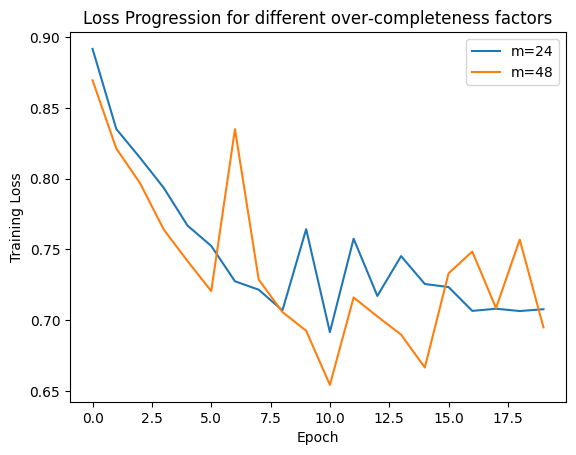

In [74]:
import matplotlib.pyplot as plt

plt.figure()
for m, losses in zip(overcomps, all_losses):
    plt.plot(losses, label=f"m={m}")

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Loss Progression for different over‐completeness factors")
plt.legend()
plt.show()

In [60]:
val_loss, val_acc = evaluate(model, val_loader, criterion, device)

Validation — avg loss: 0.6704, pixel accuracy: 72.4865%


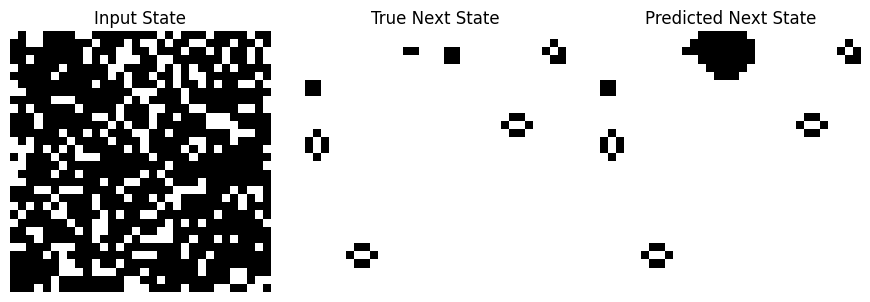

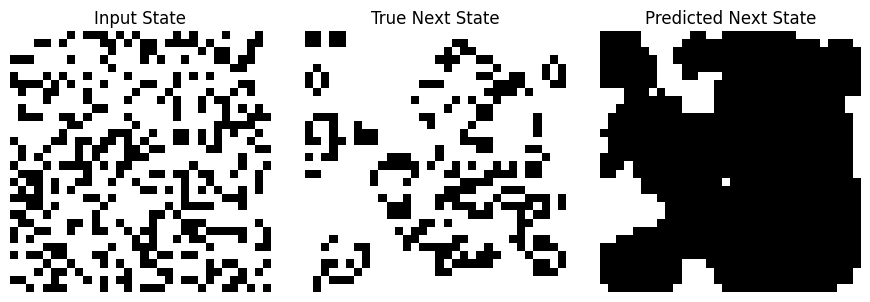

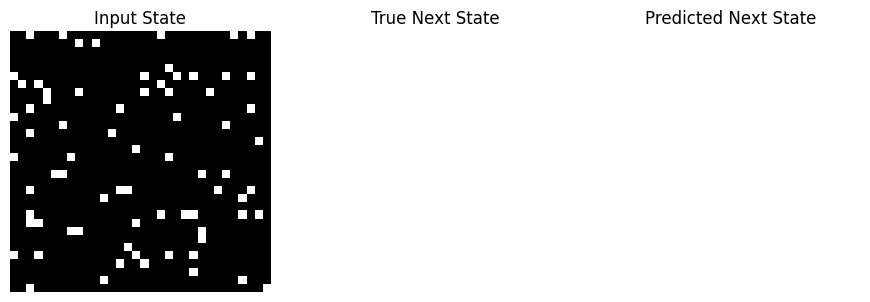

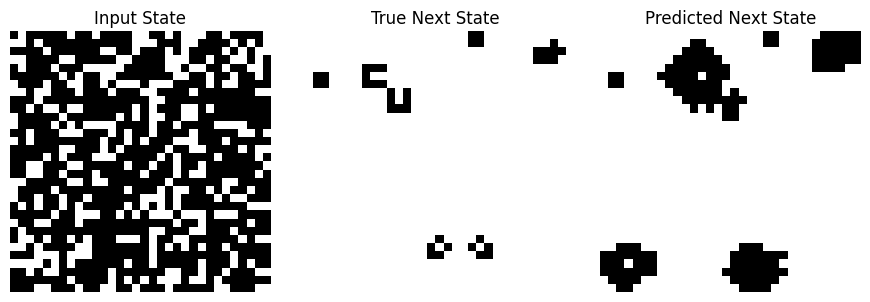

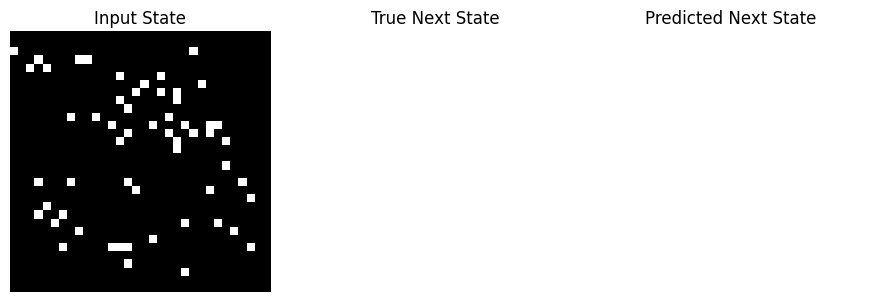

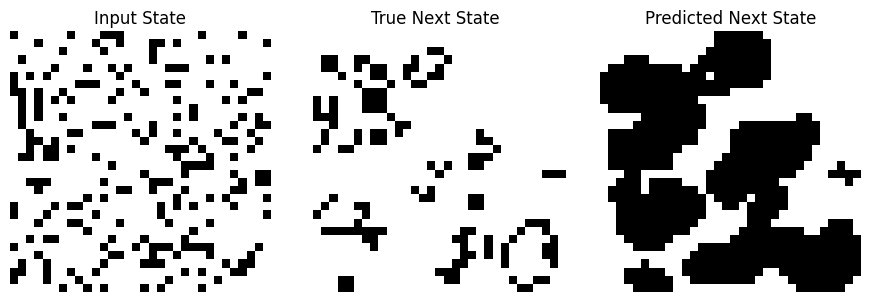

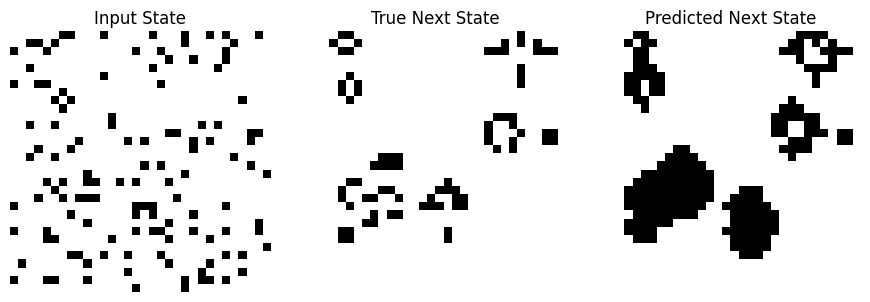

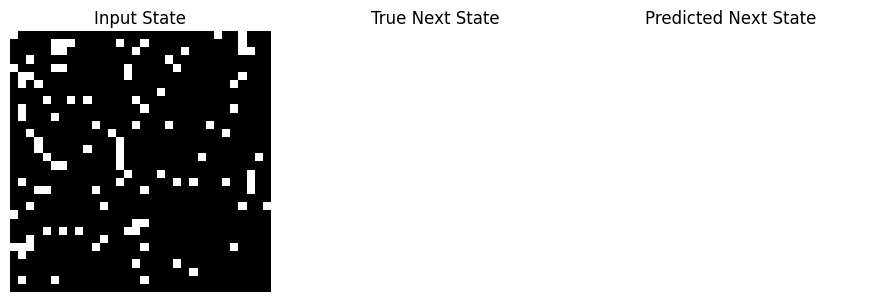

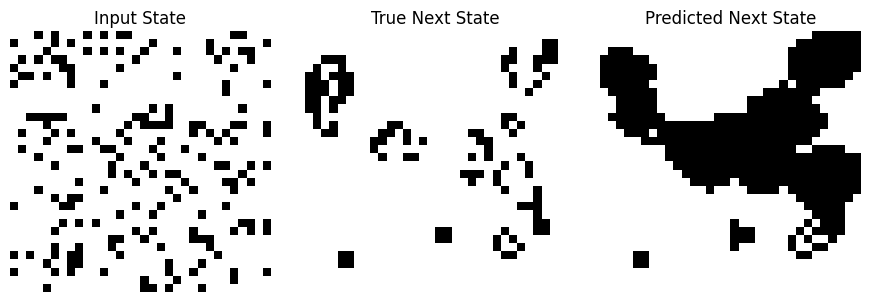

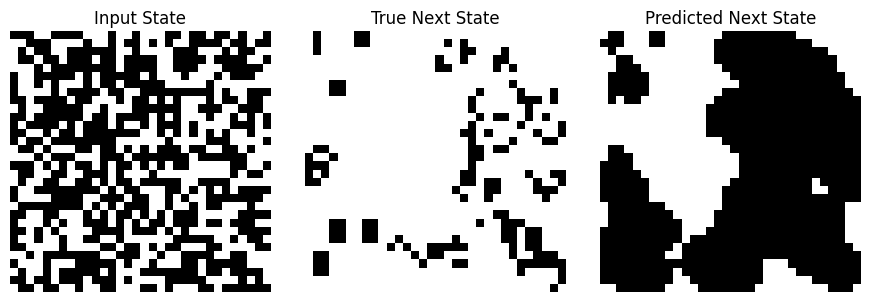

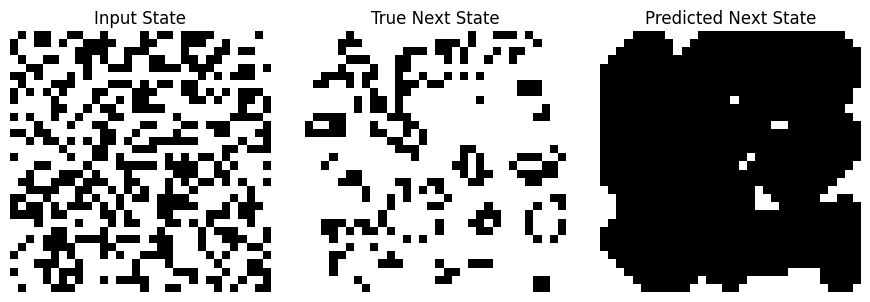

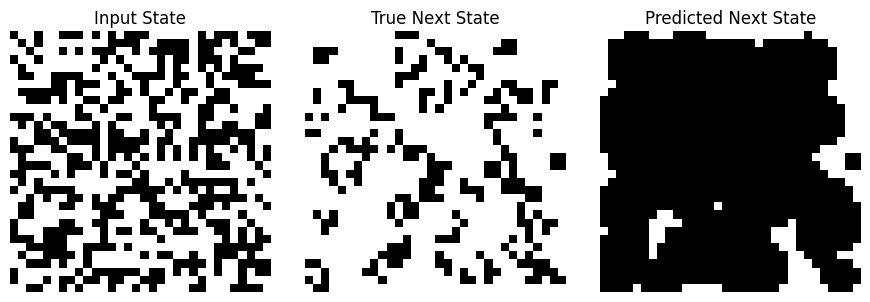

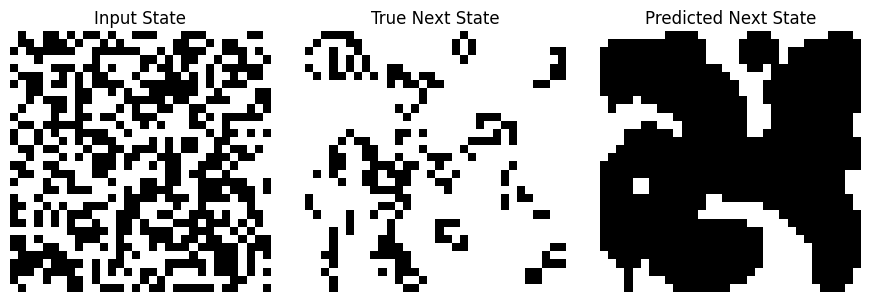

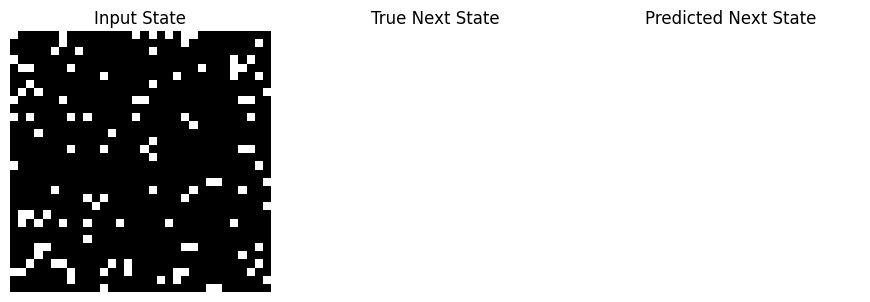

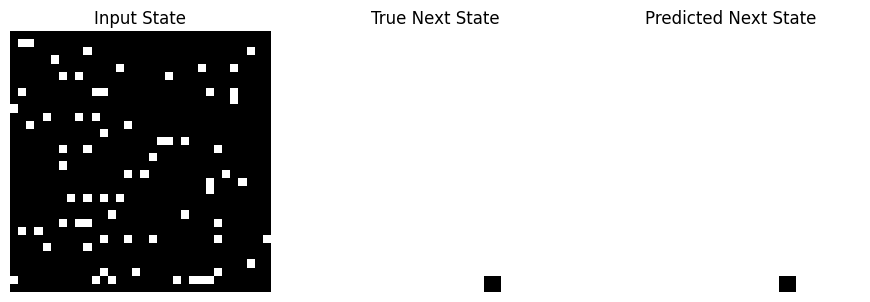

In [61]:
plot_predictions(model, val_loader, device, n_images=15)

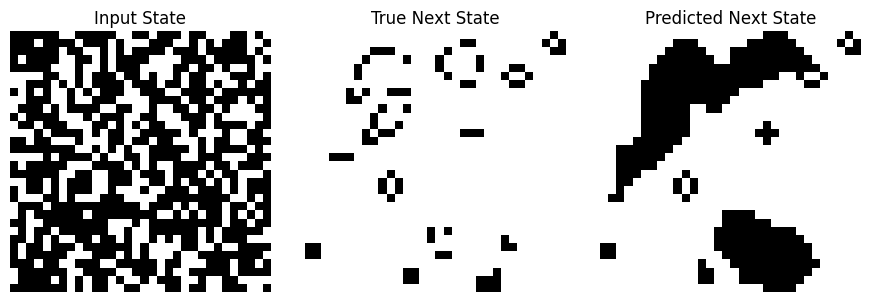

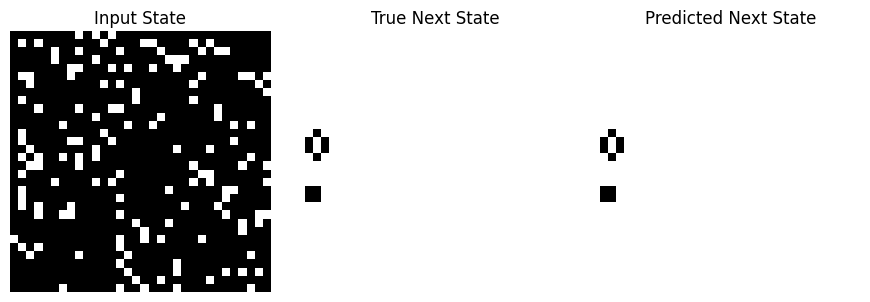

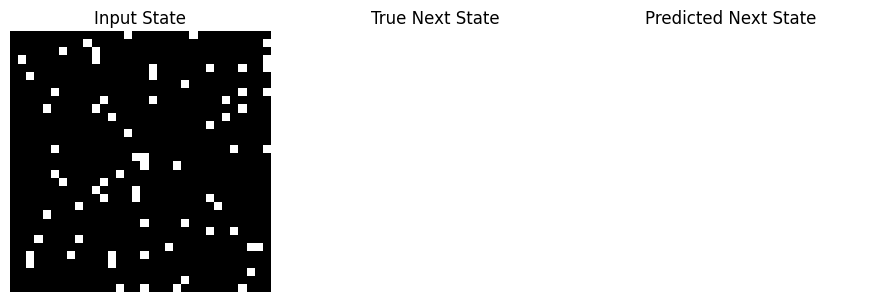

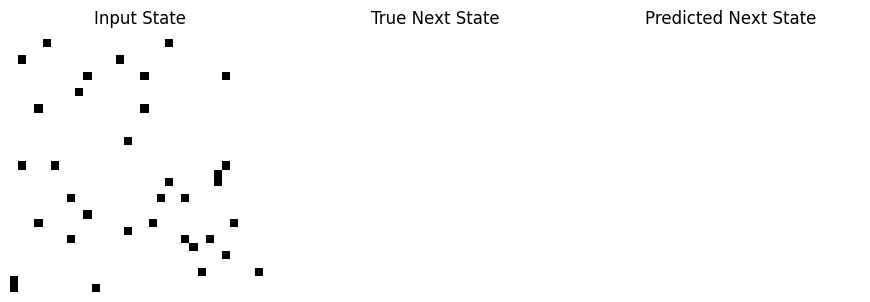

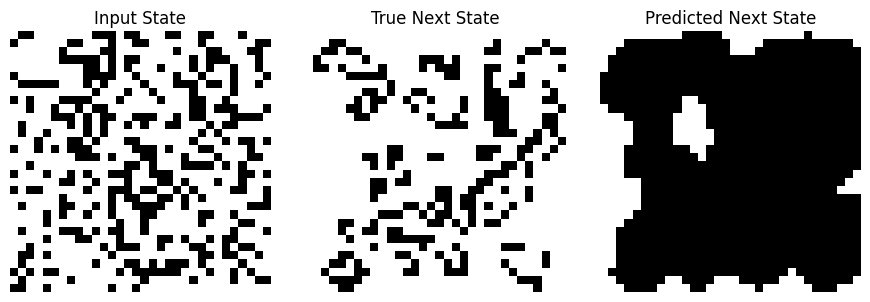

In [62]:
plot_predictions(model, train_loader, device, n_images=5)

In [63]:
PATH = "model_weights.pt"
torch.save(model.state_dict(), PATH)

In [64]:
model = Life_CNN().eval()
model.load_state_dict(torch.load("model_weights_2.pt", map_location="cpu"))
dummy = torch.randn(1,1,32,32)
torch.onnx.export(model, dummy, "life.onnx",
                  input_names=["x"], output_names=["y"],
                  dynamic_axes={"x":{0:"batch"}, "y":{0:"batch"}})

FileNotFoundError: [Errno 2] No such file or directory: 'model_weights_2.pt'